# Исследование рынка видеоигр
Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

**Цель исследования:**
1. Выбрать несколько потенциально прибыльных платформ;
2. Выделить жанры с высокими и низкими продажами;
3. Составить портрет пользователя каждого региона (популярные платформы и жанры);
4. Проверить гипотезу: "Средние пользовательские рейтинги платформ Xbox One и PC одинаковые";
5. Проверить гипотезу: "Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные".
6. Выявить определяющие успешность игры закономерности.

In [1]:
# Импортируем модули, которые понадобятся по ходу работы
import pandas as pd # Основные интсрументы анализа данных
pd.set_option('display.float_format', '{:,.2f}'.format) # Установка количества выводимых знаков после запятой
import matplotlib.pyplot as plt # Работа с диаграммами
from scipy import stats as st # Инструменты статистического анализа
import warnings # Отключение предупреждений
warnings.filterwarnings('ignore')

In [2]:
# Функция-строитель круговых диаграм топ-5 элементов столбца
def top_5_pie_chart(obj):
    plt.subplots(figsize = (18,6))
    for plot_num, region in enumerate(['na_sales', 'eu_sales', 'jp_sales']):
        # Выделяем 5 самых популярных элементов региона
        reg_obj = df_actual.groupby(obj)[[region]].sum().sort_values(by = region, ascending = False)
        top_obj = reg_obj.head()
        reg_obj = reg_obj.reset_index()
        # Меняем менее популярные элементы на 'other'
        reg_obj[obj] = reg_obj[obj].where(reg_obj[obj].isin(top_obj.index), 'other')
        (reg_obj.groupby(obj)[[region]].sum()
         .plot(kind = 'pie', subplots = True, autopct = '%1.1f%%', figsize = (6,6), legend = False,
               ax = plt.subplot(1, 3, plot_num + 1)))

In [3]:
# Функция для расчета корреляции и постройки диаграммы рассеяния между оценками и продажами
def corr_scatter_builder(platforms, score_type):
    for name in platforms:
        # Сортируем по платформе и для лучшей читаемости диаграммы удаляем выбросы
        (df_actual.query('platform == @name and total_sales < total_sales.quantile(0.99)')
         .plot(x = score_type, y = 'total_sales', kind = 'scatter', figsize = (8, 5), alpha = 0.3, title = name))
        if score_type == 'user_score':
            plt.xlabel('Пользовательская оценка')
        else:
            plt.xlabel('Оценка критиков')
        plt.ylabel('Проданных копий, млн шт.')
        # Коэффициент корреляции
        print(f"Коэффициент корреляции для платформы {name}: {df_actual[df_actual['platform'] == name]['total_sales'].corr(df_actual[df_actual['platform'] == name][score_type].astype(float))}")

In [4]:
# Функция для проверки гипотез на основе ttest_ind
def hypothesis_check(obj_type, objects, values, alpha):
    alpha = alpha
    # Выделяем данные, удовлетворяющие заданным критериям
    first_rating = df_actual[df_actual[obj_type] == objects[0]][values].dropna()
    second_rating = df_actual[df_actual[obj_type] == objects[1]][values].dropna()
    # Проводим расчет
    results = st.ttest_ind(first_rating, second_rating)
    print('p-значение:', results.pvalue)
    if (results.pvalue < alpha):
        print("Отвергаем нулевую гипотезу.")
    else:
        print("Не получилось отвергнуть нулевую гипотезу.")

## Изучение и обработка данных из файла
Для работы с таблицей нам необходимо импортировать библиотеку Pandas и воспользоваться встроенной в нее функцией чтения файла в переменную.

In [5]:
df = pd.read_csv('/datasets/games.csv') # В переменную df сохраняем прочитанный файл данных
df.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,"2,006.00",Sports,41.36,28.96,3.77,8.45,76.00,8,E
1,Super Mario Bros.,NES,"1,985.00",Platform,29.08,3.58,6.81,0.77,nan,NaN,NaN
2,Mario Kart Wii,Wii,"2,008.00",Racing,15.68,12.76,3.79,3.29,82.00,8.3,E
3,Wii Sports Resort,Wii,"2,009.00",Sports,15.61,10.93,3.28,2.95,80.00,8,E
4,Pokemon Red/Pokemon Blue,GB,"1,996.00",Role-Playing,11.27,8.89,10.22,1.00,nan,NaN,NaN
5,Tetris,GB,"1,989.00",Puzzle,23.20,2.26,4.22,0.58,nan,NaN,NaN
6,New Super Mario Bros.,DS,"2,006.00",Platform,11.28,9.14,6.50,2.88,89.00,8.5,E
7,Wii Play,Wii,"2,006.00",Misc,13.96,9.18,2.93,2.84,58.00,6.6,E
8,New Super Mario Bros. Wii,Wii,"2,009.00",Platform,14.44,6.94,4.70,2.24,87.00,8.4,E
9,Duck Hunt,NES,"1,984.00",Shooter,26.93,0.63,0.28,0.47,nan,NaN,NaN


Выведем на экран и изучим общую информацию о таблице:

In [6]:
df.info() # Выводим общую информацию о таблице на экран

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Таблица имеет 11 столбцов с данными различных типов. Согласно документации:
* `Name` — название игры;
* `Platform` — платформа;
* `Year_of_Release` — год выпуска;
* `Genre` — жанр игры;
* `NA_sales` — продажи в Северной Америке (миллионы проданных копий);
* `EU_sales` — продажи в Европе (миллионы проданных копий);
* `JP_sales` — продажи в Японии (миллионы проданных копий);
* `Other_sales` — продажи в других странах (миллионы проданных копий);
* `Critic_Score` — оценка критиков (максимум 100);
* `User_Score` — оценка пользователей (максимум 10);
* `Rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Количество значений в столбцах различается. Значит, в данных есть пропущенные значения.

### Замена названий столбцов
Заменим названия столбцов, приведя все буквы к нижнему регистру:

In [7]:
df.columns = df.columns.str.lower()

### Обработка пропусков
* Стоблец `name` содержит два пропуска - целесообразно их удалить.
* Пропущенные значения в столбце `year_of_release` составляют меньше 0.1% от общего количества значений. Возможно попытаться восстановить их, сгруппировав по годам и жанрам - вероятно, игра с определенным жанром была выпущена в год, когда этот жанр был наиболее популярен. Но, я думаю, вероятность промаха остается высока. В идеале - запарсить по паре "название + жанр", и получить оттуда год релиза.
* Два пропуска в столбце `genre` уйдут при очистке столбца `name`.
* Больше всего пропусков в столбцах с оценками, около 50%. Заполнять их каким-либо расчетным значением нецелесообразно - потеряется реальна картина. В реальном проекте путь решения такой же - оценки находятся в открытом доступе, и парсятся по паре "название + год релиза".
* Значения "TBD" в этих столбцах также заполним пропусками - поскольку они не несут в себе никакой информации кроме "будет известно позднее".
* Пропуски в столбце `rating` заполним заглушкой `NR` - "No Rating".

In [8]:
df.drop(df[df['name'].isna() == True].index, inplace = True) # Удаляем строки, в которых пропущено название игры
df.loc[df['user_score'] == 'tbd', 'user_score'] = float('nan') # Заменяем 'tbd' на 'nan'
df['rating'] = df['rating'].fillna('NR') # Заполняем пропуски в столбце рейтинга

### Изменение типов данных

Разумно изменить тип столбцов `year_of_release` и `critic_score` на `Int64` - так как, в первом случае, столбец содержит данные только о годе релиза игры, а во втором случае оценки выставляются в диапазоне 1-100 целыми числами.
Столбец `user_score` приведем к типу `float64`.

In [9]:
column = ['critic_score', 'year_of_release'] # Столбцы, тип которых меняется на Int64
for name in column:
    df[name] = df[name].astype('Int64') # Используем Int64 вместо Int, т.к. столбец содержит пропуски
df['user_score'] = df['user_score'].astype('float')

### Подсчет суммарных продаж
Создадим столебец `total_sales` и посчитаем в него суммарное количество продаж для каждой игры:

In [10]:
df.insert(8,'total_sales', 0) # Создаем столбец 'total_sales' после всех столбцов о продажах
df['total_sales'] = df[['na_sales','eu_sales','jp_sales','other_sales']].sum(axis=1) # Заполняем столбец данными

### Удаление дубликатов
Проверим таблицу на наличие дубликатов.<br>
Как указано в задании, каждую строку стоит рассматривать как отдельную игру, даже если она ялвяется бандлом, в который входит уже приведенная в таблице игра. Соотвественно, неявные дубликаты будем искать только в столбцах `platform` и `genre`.

In [11]:
print('Уникальные платформы:', df['platform'].unique())
print('Уникальные жанры:', df['genre'].unique())
print('Количество дубликатов:', df.duplicated().sum())

Уникальные платформы: ['Wii' 'NES' 'GB' 'DS' 'X360' 'PS3' 'PS2' 'SNES' 'GBA' 'PS4' '3DS' 'N64'
 'PS' 'XB' 'PC' '2600' 'PSP' 'XOne' 'WiiU' 'GC' 'GEN' 'DC' 'PSV' 'SAT'
 'SCD' 'WS' 'NG' 'TG16' '3DO' 'GG' 'PCFX']
Уникальные жанры: ['Sports' 'Platform' 'Racing' 'Role-Playing' 'Puzzle' 'Misc' 'Shooter'
 'Simulation' 'Action' 'Fighting' 'Adventure' 'Strategy']
Количество дубликатов: 0


Явных дубликатов в таблице нет. Среди жанров и платформ неявных дубликатов также не найдено.

### Вывод 
В разделе были изменены названия столбцов так, чтобы они соответствовали принятому стилю. Частично были обработаны пропуски - удалены строки без названий, пропуски в рейтинге были заменены заглушками. Для столбцов `year_of_release` и `critic_score` тип был изменен на `Int64`. Был добавлен столбец `total_sales` с суммарным количеством проданных копий каждой игры. Обоснования принятых решений описаны в каждом подразделе соответственно.<br>
Взглянем на результат работы, проделанной в разделе:

In [12]:
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,total_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,82.54,76,8.00,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,40.24,NaN,nan,NR
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,35.52,82,8.30,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,32.77,80,8.00,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,31.38,NaN,nan,NR


## Исследовательский анализ данных
### Количество выпускаемых игр
Подсчитаем количество игр, выпускавшихся в разные годы на разных платформах, и построим по этим данным график:

Text(0, 0.5, 'Проданных копий, млн шт.')

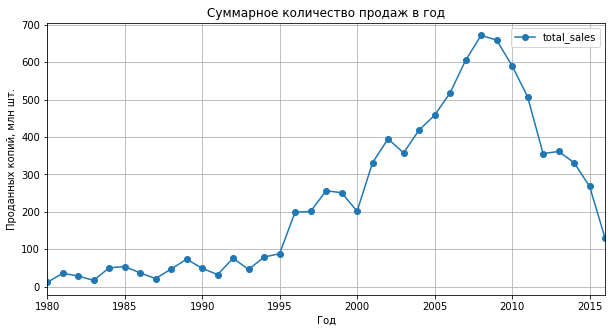

In [13]:
(df.pivot_table(index = 'year_of_release', values = 'total_sales', aggfunc = 'sum')
 .plot(figsize = (10,5), grid = True, style = '-o', title = 'Суммарное количество продаж в год'))
plt.xlabel('Год')
plt.ylabel('Проданных копий, млн шт.')

Как видно из графика, активный рост рынка начался в 1995 году - с выходом на рынок PS1. В целом, с этого момента рынок начинают занимать 4 платформы - PC, Xbox, PlayStation и Nintendo. Поэтому логично анализировать рынок уже после этого момента. Однако, со временем меняются и предпочтения геймеров, потому для определения потенциально успешного продукта нужно опираться на максимально свежие данные. <br>
Падение в конце графика может быть связано с тем, что данные за 2016 год могут быть неполными, согласно описанию данных.

### Суммарные продажи
Изучим, как менялись продажи по платформам. Для этого выберем 10 платформ с наибольшими суммарными продажами и постром распределение по годам.

Text(0, 0.5, 'Проданных копий, млн шт.')

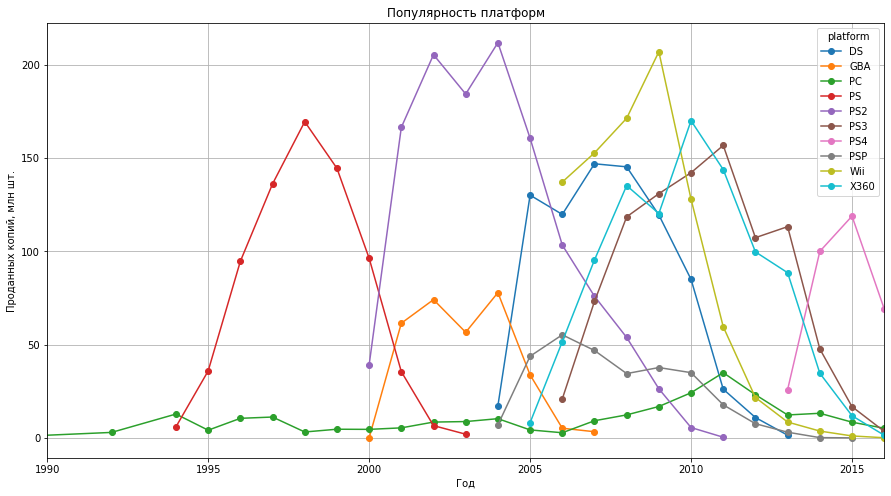

In [14]:
# Получим названия 10 платформ с наибольшим количеством суммарных продаж
platform_sales = df.groupby('platform').agg({'total_sales': 'sum'}).sort_values(by = 'total_sales').tail(10).index
# Строим график продаж по годам для каждой платформы
(df.query('platform in @platform_sales')
 .pivot_table(index = 'year_of_release', columns = 'platform', values = 'total_sales', aggfunc = 'sum')
 .plot(figsize = (15,8), grid = True, xlim=1990, style = '-o', title = 'Популярность платформ'))
plt.xlabel('Год')
plt.ylabel('Проданных копий, млн шт.')

В соответствии с графиком, в топ-10 платформ с наибольшим количеством проданных игр вошли DS, GBA и Wii (Nintendo); PS, PS2, PS3, PS4 и PSP (Sony); Xbox 360 (Microsoft); PC.<br>

### Выделение актуального периода

Судя по приведенному выше графику, характерный срок жизни поколения консолей составляет 7-8 лет, что соотвествует реальным данным. Исходя из того, что в задании указано время проведения исследования - декабрь 2016, обозначим **актуальный период** - он придется на 8 поколение консолей, которое начинается с **2012** года - с выходом на рынок Wii U, а чуть позднее - PS4 и XBox One.<br>
Таким образом, актуальный период лежит в рамках **2012-2017** гг.

In [15]:
# Создаем новую таблицу
df_actual = df.query('year_of_release >= 2012').reset_index(drop = True)

# Удаляем платформы, попавшие концом своего существования в таблицу
df_actual.drop(df_actual[df_actual['platform'] == 'DS'].index, inplace = True)
print('Количество элементов актуальной таблицы:', len(df_actual))
df_actual.head()

Количество элементов актуальной таблицы: 2855


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,total_sales,critic_score,user_score,rating
0,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,21.05,97,8.20,M
1,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,16.27,97,8.10,M
2,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,14.63,NaN,nan,NR
3,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,14.60,NaN,nan,NR
4,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,13.79,83,5.30,M


### Потенциально прибыльные платформы
Изучим актуальные платформы: какие лидируют по продажам, какие растут или падают. Исходя из этого выберем несколько потенциально прибыльных платформ.<br>
Для этого построим сводную таблицу с количеством продаж и график, подобный приведенному в П. 2.2, и сопоставим полученные данные:

,total_sales
platform,
PS4,314.14
PS3,288.79
X360,236.54
3DS,194.61
XOne,159.32
WiiU,82.19
PC,62.65
PSV,49.18
Wii,35.37


([<matplotlib.axis.XTick at 0x7fa5fb4b9590>,
 <a list of 5 Text xticklabel objects>)

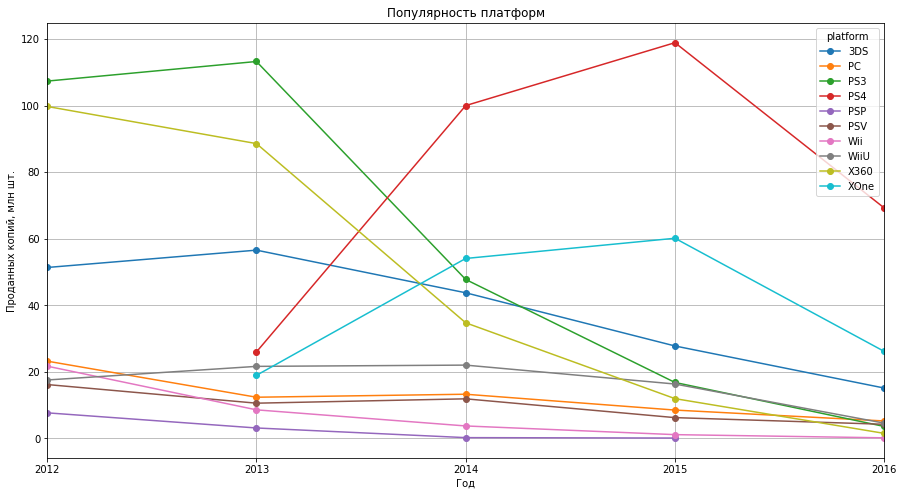

In [16]:
# Сводная таблица по продажам на каждой платформе на актуальном временном промежутке
display(df_actual.pivot_table(index = 'platform', values = 'total_sales', aggfunc = 'sum')
                .sort_values(by='total_sales', ascending = False))

# Строим график продаж по годам для каждой платформы
(df_actual.pivot_table(index = 'year_of_release', columns = 'platform', values = 'total_sales', aggfunc = 'sum')
 .plot(figsize = (15,8), grid = True, style = '-o', title = 'Популярность платформ'))
plt.xlabel('Год')
plt.ylabel('Проданных копий, млн шт.')
plt.xticks(range(min(df_actual['year_of_release']), max(df_actual['year_of_release'])+1))

Лидерами по продажам на актуальном отрезке являются PS4, PS3, Xbox 360, 3DS и XOne. Cудя по графику, жизненный цикл PS3 и Xbox 360 как раз подходит к концу во время проведения исследования (консоли вышли на рынок в 2006 и 2005 соответсвенно). Аналогичная ситуация с падением популярности присуща практически всем платформам, за исключением трех - PS4, Xbox One и PC:
* Первые две вышли на рынок в 2013 и еще набирают свою популярность (падение в конце графика связано, скорее всего, с неполнотой данных за 2016 год);
* Популярность 3DS на актуальном промежутке снижается, но находится на третьем месте по объему продаж;
* Популярность компьютера как игровой платформы хоть и не высока, она всегда держится примерно на одном уровне.

Платформы вроде Wii U и PS Vita имеют нисходящий тренд буквально с момента выхода на рынок.<br>
Более старые платформы не рассматриваются в связи с тем, что их жизненный цикл подходит к концу, и надеяться на увеличение спроса на них бессмысленно.

По итогу выделяются четыре потенциально прибыльные платформы: **PlayStation 4, Xbox One, PC и Nintendo 3DS.**

### Boxplot  по глобальным продажам


Text(0, 0.5, 'Проданных копий, млн шт.')

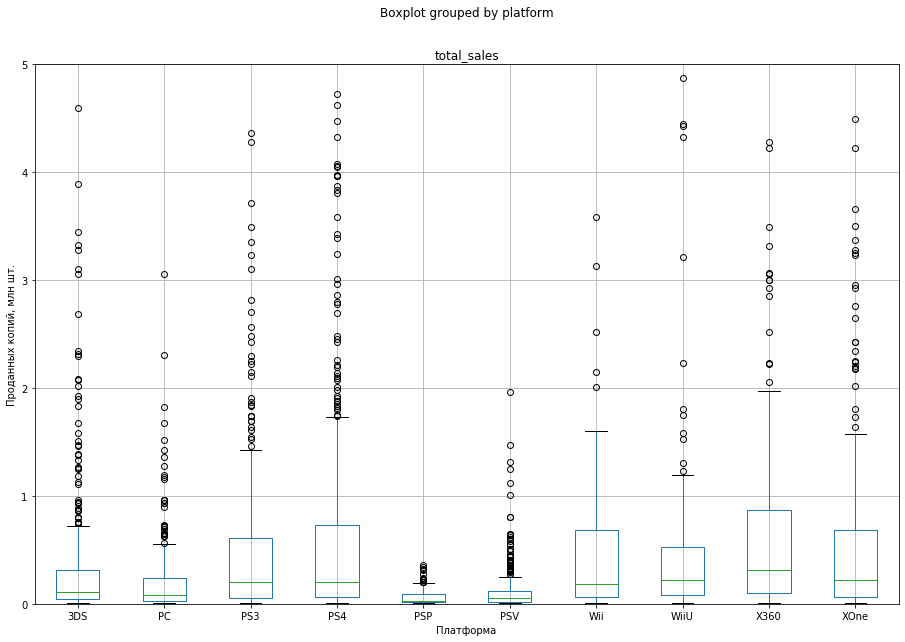

In [17]:
df_actual.boxplot(column = 'total_sales', by = 'platform', figsize = (15,10))
plt.ylim(0, 5)
plt.xlabel('Платформа')
plt.ylabel('Проданных копий, млн шт.')

Распределение подтверждает выводы, сделанные выше - судя по медианным значениям, больше всего продаж на актуальном промежутке времени имеют PS3, Xbox 360 и Wii. С небольшим отставанием идут консоли актуального поколения - PS4, Xbox One и Wii U.<br>
Маленький ящик и много выбросов говорит о том, что большАя часть объема продаж делается за счет этих выбросов. В то же время большой бокс, длинный ус и малое количество выбросов свидетельствует о том, что пользователи покупают самые разные игры, причем, в немалом количестве.<br>
Хоть медианные значения продаж и не высоки, на диаграмме присутствует много выбросов - очевидно, есть популярные релизы, количество продаж которых в разы превыает средние показатели по платформе. Далее изучим, с чем это может быть связано.

### Связь между отзывами и продажами
Посмотрим, как влияют на продажи внутри двух популярных платформ отзывы пользователей и критиков. Для этого воспользуемся собственной функцией `corr_scatter_builder`, которая строит диаграмму рассеяния и рассчитывает корреляцию между отзывами и продажами.

Сначала рассмотрим связь с **пользовательскими оценками**:

Коэффициент корреляции для платформы PS4: -0.031957110204556424
Коэффициент корреляции для платформы XOne: -0.06892505328279412


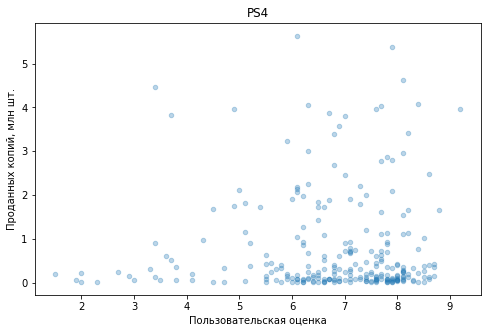

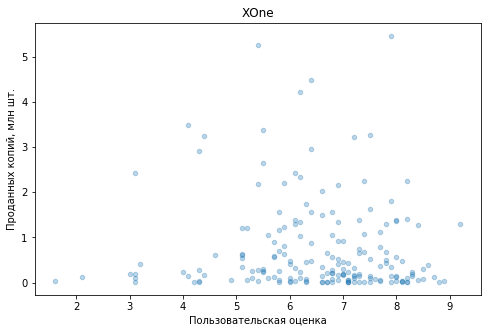

In [18]:
platforms = ['PS4', 'XOne']
corr_scatter_builder(platforms, 'user_score')

Судя по коэффициентам корреляции, зависимость между пользовательскими оценками и количеством проданных копий довольно слабая. Однако это противоречит диаграммам - на них видно, что чем большую оценку имеет игра, тем более успешно она показывает себя на рынке.<br>
Это связано с тем, что коэффициент корреляции показывает линейную зависимость, а в нашем случае зависимость нелинейная.

Далее рассмотрим связь с **оценками критиков**:

Коэффициент корреляции для платформы PS4: 0.406567902061781
Коэффициент корреляции для платформы XOne: 0.41699832800840175


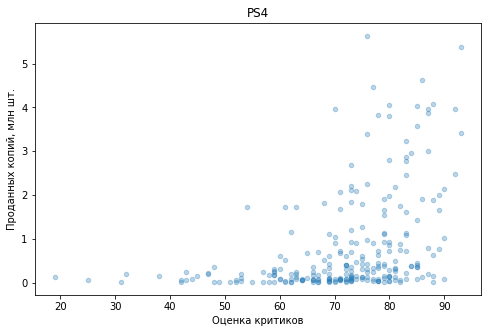

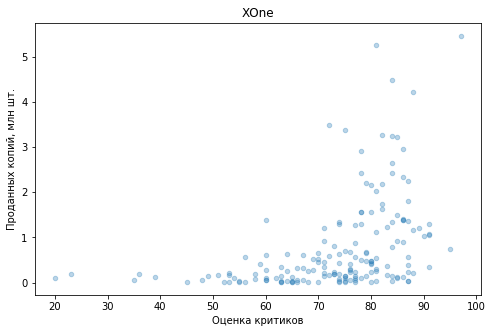

In [19]:
platforms = ['PS4', 'XOne']
corr_scatter_builder(platforms, 'critic_score')

Схожая с оценками пользователей картина, только наблюдается более сильная корреляция. Она же подтвержается диаграммами - точки на них расположены более кучно, и по мере увеличения оценки, увеличивается и число продаж.

### Распределение по жанрам
Посмотрим на общее распределение игр по жанрам. Выделим жанры с высокими и низкими продажами.

In [20]:
df_actual.pivot_table(index = 'genre', values = 'total_sales', aggfunc = 'sum').sort_values(by='total_sales', ascending = False)

,total_sales
genre,
Action,439.30
Shooter,304.73
Role-Playing,183.72
Sports,180.96
Misc,84.56
Platform,60.31
Racing,53.50
Fighting,44.49
Simulation,34.91


Наиболее популярным жанром является *Экшен* с почти 450 млн продаж на актуальном отрезке времени. Это довольно широкое понятие, и в этот жанр могут входить как файтинги и шутеры, так и платформеры - но в нашем случае эти жанры вынесены отдельными элементами, так что самым популярным все-таки будем считать именно **Экшен** в широком понятии.<br>
На втором месте находится жанр шутеров с 300 млн продаж; чуть менее, чем в 1.5 раза более скромный результат показали жанры *спорт* и *RPG*.<br>
Наименее популярными жанрами являются *паззлы* и *стратегии* - в среднем 18 миллионов проданных копий каждого жанра за 5 лет.<br>

Для каждого жанра посчитаем количество выпущенных игр и медианное число продаж. Для жанров Action, Shooter, Role-Playing, Sports посчитаем количество игр, продавшихся тиражом более 5 млн (назовем их "бестселлерами").

In [21]:
display(df_actual.pivot_table(index = 'genre', values = 'total_sales', aggfunc = ('count', 'median'))
        .sort_values(by='count', ascending = False))
for genre in ['Action', 'Shooter', 'Role-Playing', 'Sports']:
    print(f"Количество бестселлеров жанра {genre}: {df_actual.query('genre == @genre & total_sales > 5')['name'].count()}")

,count,median
genre,,
Action,1016,0.12
Role-Playing,368,0.14
Adventure,299,0.03
Sports,266,0.24
Shooter,235,0.44
Misc,190,0.12
Racing,115,0.14
Fighting,109,0.13
Platform,83,0.21


Количество бестселлеров жанра Action: 9
Количество бестселлеров жанра Shooter: 12
Количество бестселлеров жанра Role-Playing: 5
Количество бестселлеров жанра Sports: 4


Видно, что самое большое медианное значение продаж имеет жанр Shooter. Как и ожидалось, жанр Action превосходит своих конкурентов по количеству выпущенных игр практически в 3 раза - отсюда и большое общее количество продаж. Однако медианное количество продаж ниже всех рассматриваемых жанров.<br>
Судя по количеству бестселлеров, жанр Action имеет большое количество только из-за большого количества игр.<br>
Жанр Shooter представлен всего 235 играми, имеет медианное количество продаж около 0.45 млн и самое большое количество бестселлеров.

Посмотрим на популярность жанров по годам: 

([<matplotlib.axis.XTick at 0x7fa5f9996610>,
 <a list of 5 Text xticklabel objects>)

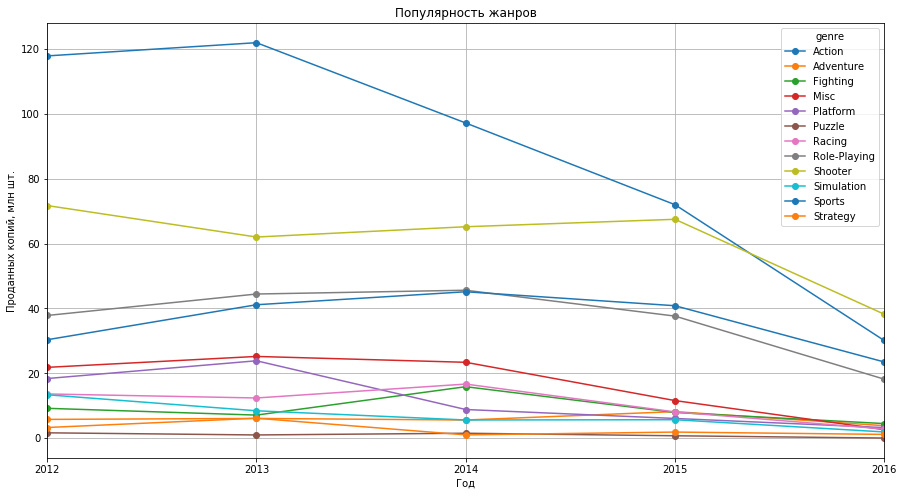

In [22]:
# Строим график продаж по годам для каждой платформы
(df_actual.pivot_table(index = 'year_of_release', columns = 'genre', values = 'total_sales', aggfunc = 'sum')
 .plot(figsize = (15,8), grid = True, style = '-o', title = 'Популярность жанров'))
plt.xlabel('Год')
plt.ylabel('Проданных копий, млн шт.')
plt.xticks(range(min(df_actual['year_of_release']), max(df_actual['year_of_release'])+1))

График выглядит неутешительно - общее число продаж падает. Однако, жанры экшен, шутер, спорт и RPG находятся значительно выше остальных на графике.<br>
Заметно, что за последние два года (не включая 2016, т.к. данные о нем неполные) жанр шутеров набирает популярность, в то время как экшен ее стремительно теряет.

### Вывод
В разделе мы выяснили, что количество выпускаемых игр в последние годы снизилось. Актуальным был выбран период **2012-2017 гг.** Потенциально прибыльными платформами были названы **PlayStation 4, Xbox One, PC и Nintendo 3DS.** Было установлено, что количество продаж сильнее коррелирует с отзывами критиков, чем игроков - чем выше оценка, тем больше продаж. Наиболее актуальные жанры - **Action** или **Shooter**.

## Портрет типичного пользователя
Составим портрет типичного пользователя для каждого из регионов: на каких платформах и в какие жанры играет. Изучим, влияет ли рейтинг ESRB на продажи в отдельном регионе.

### Топ-5 платформ
Выделим самые популярные платформы у пользователей разных регионов. Воспользуемся собственной функцией `top_5_pie_chart`, которая строит пайчарты пяти самых популярных элементов столбца для каждого региона:

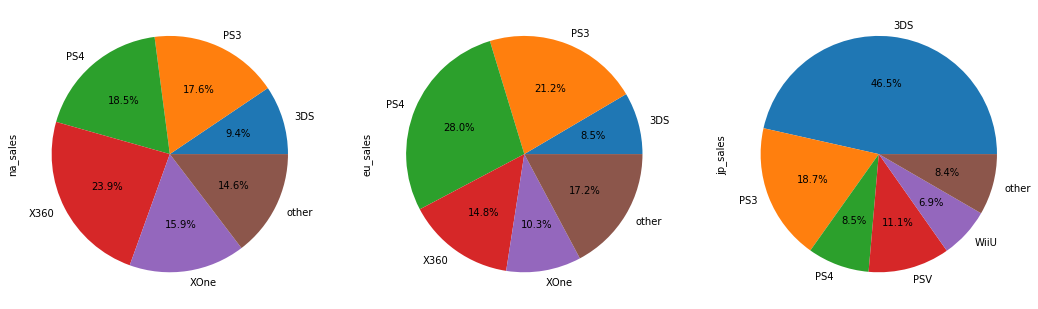

In [23]:
top_5_pie_chart('platform')

Топ-5 платформ в каждом регионе на актуальном промежутке времени в порядке убывания популярности:<br>
**Северная Америка:**
* Xbox 360
* PlayStation 4
* PlayStation 3
* Xbox One
* Nintendo 3DS

**Европа:**
* PlayStation 4
* PlayStation 3
* Xbox 360
* Xbox One
* Nintendo 3DS

**Япония:**
* Nintendo 3DS
* PlayStation 3
* PlayStation Vita
* PlayStation 4
* Nintendo Wii U

Пользователи из Америки и Европы выбирают схожие платформы, в Японии выбирают местных производителей - Sony и Nintendo.<br>
Из названных "потенциально прибыльными" платформ не появляется только PC.

### Топ-5 жанров
Аналогичным образом выделим популярные жанры:

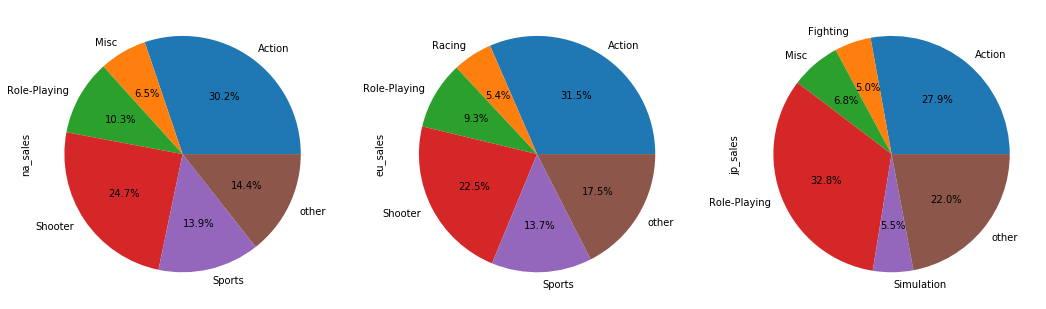

In [24]:
top_5_pie_chart('genre')

Топ-5 жанров в каждом регионе на актуальном промежутке времени в порядке убывания популярности:<br>
**Северная Америка:**
* Action
* Shooter
* Sports
* Role-Playing
* Misc

**Европа:**
* Action
* Shooter
* Sports
* Role-Playing
* Racing

**Япония:**
* Role-Playing
* Action
* Misc
* Simuulation
* Fighting

Предпочтения по жанрам в Америке и Европе, самых больших рынках, практически совпадают - пользователи любят экшены, шутеры, спортивные и ролевые игры. Пользователи из Японии предпочитают в основном ролевые игры и экшен.

### Влияние рейтинга ESRB на продажи
Проверим, влияет ли рейтинг ESRB на продажи в отдельном регионе. Не будем брать в расчет значения-заглушки "RP" (Rating Pending).

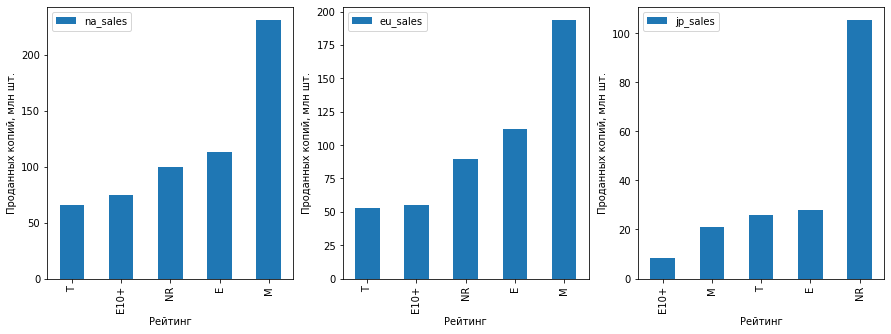

In [25]:
plt.subplots(figsize = (15,5))
regions = ['na_sales', 'eu_sales', 'jp_sales']
for plot_num, region in enumerate(regions):
    (df_actual.query('rating != "RP"')
     .pivot_table(index = 'rating', values = region, aggfunc = 'sum')
     .sort_values(region)
     .plot(kind = 'bar', ax = plt.subplot(1, len(regions), plot_num + 1)))
    plt.xlabel('Рейтинг')
    plt.ylabel('Проданных копий, млн шт.')

Видно, что в Северной Америке и Европе преобладают  продажи игр с рейтингами M (Mature), на втором месте (почти в два раза меньше) располагается рейтинг E (Everyone). В Японии преобладают продажи игр без рейтинга, и причин этому может быть несколько: внутренние релизы японии часто не имеют рейтинга ESRB, либо у нас нет информации по этим релизам - в любом случае, это небольшой самобытный рынок, и если интересен именно он, с ним придется работать отдельно.

### Вывод
По итогам исследования, проведенного в разделе, можно обозначить следующий портрет типичного пользователя:

**Для Северной Америки:**<br>
Пользуется **Xbox 360** или **PlayStation 4**, предпочитает игры жанра **экшен** или **шутер** с рейтингом **M** или **Е**. 

**Для Европы:**<br>
Пользуется **PlayStation 4** или **PlayStation 3**, предпочитает игры жанра **экшен** или **шутер** с рейтингом **M** или **E**. 

**Для Японии:**<br>
Пользуется **Nintendo 3DS** или **PlayStation 3**, предпочитает игры жанра **RPG** или **экшен** без рейтинга вообще или с рейтингом **Е**. 


## Проверка гипотез
### Сравнение рейтингов Xbox One и PC
Нулевая гипотеза звучит как "средние пользовательские рейтинги платформ Xbox One и PC одинаковые". Тогда альтернативная гипотеза будет звучать как "средние пользовательские рейтинги платформ Xbox One и PC разные".<br>
Воспользуемся собственной функцией `hypothesis_check`. Задаем критический уровень статистической значимости равным 5%, так как это стандартное значение для исследований.

In [26]:
objects = ['XOne', 'PC']
hypothesis_check('platform', objects, 'user_score', 0.05)

p-значение: 0.5535080500643661
Не получилось отвергнуть нулевую гипотезу.


Принимаем решение, что нулевая гипотеза верна - средние пользовательские рейтинги на Xbox One и PC равны. Подчитаем их:

In [27]:
for item in ['XOne', 'PC']:
    print(f'Средний пользователский рейтинг на {item} равен {df_actual[df_actual["platform"] == item]["user_score"].mean()}')

Средний пользователский рейтинг на XOne равен 6.521428571428572
Средний пользователский рейтинг на PC равен 6.428640776699029


Разница равна примерно 0.1 балла, что составляет всего 1%.

### Сравнение жанров Action и Sports
Нулевая гипотеза звучит как "cредние пользовательские рейтинги жанров Action и Sports одинаковые". В таком случае, альтернативная гипотеза будет звучать как "cредние пользовательские рейтинги жанров Action и Sports разные".<br>
Критический уровень статистической значимости оставляем равным 5%.

In [28]:
objects = ['Action', 'Sports']
hypothesis_check('genre', objects, 'user_score', 0.05)

p-значение: 3.3809723133310956e-26
Отвергаем нулевую гипотезу.


Принимаем, что нулевая гипотеза не верна. Судя по p-значению, вероятность равенства среднего пользовательского рейтинга жанров Action и Sports очень мала. В таком случае, посчитаем среднее значение рейтинга для каждого жанра, сравним их и сделаем вывод.

In [29]:
for item in ['Action', 'Sports']:
    print(f'Средний пользователский рейтинг жанра {item} равен {df_actual[df_actual["genre"] == item]["user_score"].mean()}')

Средний пользователский рейтинг жанра Action равен 6.826679462571977
Средний пользователский рейтинг жанра Sports равен 5.455897435897437


Разница равна примерно 1.4 балла, что составляет уже 14%.

### Вывод
По итогам работы раздела, гипотеза о равенстве рейтингов на Xbox One и PC была принята. Гипотеза о равенстве рейтингов жанров Action и Sports была отвергнута - средний рейтинг жанра Action выше.

## Общий вывод
В ходе работы были изучены исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы. Согласно условиям, исследование проводится в декабре 2016 года, задание - спланировать рекламную кампанию на 2017 год.

На первом этапе данные в таблице были приведены к нужным типам, в данных были устанены незначительные ошибки. В таблицу был добавлен столбец с данными о суммарных продажах каждой игры во всех представленных регионах.

По итогам исследовательского анализа данных были сделаны следующие выводы:
* Количество ежегодных продаж падает с *2009* года.
* На промежутке *1990-2017* гг. в топ-10 платформ с наибольшим количеством проданных игр вошли DS, GBA и Wii (Nintendo); PS, PS2, PS3, PS4 и PSP (Sony); Xbox 360 (Microsoft); PC.
* Актуальным для дальнейшего исследования периодом был выбран **2012-2017** гг.
* Потенциально прибыльными платформами были выбраны **PlayStation 4**, **Xbox One**, **PC** и **Nintendo 3DS**, т.к. они находятся в начале своего жизненного цикла.
* В среднем указанные платформы на исследуемом промежутке времени уже имеют сравнимое с лидерами предыдущего поколения (PS3 и Xbox 360) число продаж - учитывая, что на рынке они находятся чуть меньше половины периода.
* Прослеживается похожая на линейную зависимость между оценками и количеством проданных копий игры - причем оценки критиков имеют большее влияние, чем оценки игроков.
* Наиболее популярными жанрами являются **Action**, **Shooter**, **Sports** и **RPG**. За последние два года (не включая *2016*, т.к. данные о нем неполные) жанр **Shooter** набирает популярность, в то время как **Action** ее теряет.
* Рынки Серевной Америки и Европы очень похожи по своим предпочтениям платформ и жанров.
* Гипотеза о равенстве средних пользовательских рейтингов на Xbox One и PC была **принята**. Разница между средними значениями составляет около 1%.
* Гипотеза о равенстве средних пользовательских рейтингов жанров Action и Sports **отвергается**. Средний пользовательский рейтинг жанра Action на 14% выше.

В ходе исследования были составлены портреты типичного пользователя каждого региона:<br>

**Для Северной Америки:**<br>
Пользуется **Xbox 360** или **PlayStation 4**, предпочитает игры жанра **экшен** или **шутер** с рейтингом **M** или **Е**. 

**Для Европы:**<br>
Пользуется **PlayStation 4** или **PlayStation 3**, предпочитает игры жанра **экшен** или **шутер** с рейтингом **M** или **E**. 

**Для Японии:**<br>
Пользуется **Nintendo 3DS** или **PlayStation 3**, предпочитает игры жанра **RPG** или **экшен** без рейтинга вообще или с рейтингом **Е**. 

По итогам работы можно дать следующую рекомендацию:<br>
Успешной в *2017* году может стать игра в жанре **Shooter** или **Action**, выпущенная на платформах **PlayStation 4**, **Xbox One**, **PC** или **Nintendo 3DS** с возрастным рейтингом **M** или **Е**, выпущенная на европейский и североамериканский рынки, и высоко оцененная критиками и игроками.